<a href="https://colab.research.google.com/github/M4mbo/Double_Deep_Q-Learning_for_FrozenLake_Env/blob/main/FROZEN_LAKE_DQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Q-Learning

The main idea behind Q-learning is that if we had a function

> Indented block


$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

But this is not scalable. Must compute $Q(s,a)$ for every state-action pair. If state is e.g. current game state pixels, computationally infeasible to compute for entire state space! But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}



### Double Deep Q-Learning

We will implement Double Deep Q-Learning here. Double Deep Q-Learning is used to reduce the maximaztion bias in Q-Learning. This entails using two separate $Q$-value estimators, each of which is used to update the other. The target values are calculated using a target Q-network. The target Q-network's parameters are updated to the current networks every $C$ time steps.

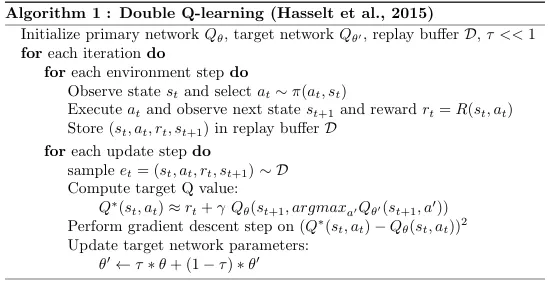

[Image Source](https://towardsdatascience.com/double-deep-q-networks-905dd8325412)

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create the environment
env = gym.make("FrozenLake-v1", is_slippery=False, new_step_api=True)

In [ ]:
# Named tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

# Cyclic buffer of bounded size that holds and samples the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
nspace = env.observation_space.n
naction = env.action_space.n
print(nspace)

16


In [ ]:
class DQN(nn.Module):
  def __init__(self, ns, na):
    super().__init__()
    self.layer1 = nn.Linear(ns, 128)
    self.layer2 = nn.Linear(128, 128)
    self.layer3 = nn.Linear(128, na)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = self.layer3(x)
    return x


In [ ]:
def get_action(state, epsilon):
  ## First we randomize a number
  exp_exp_tradeoff = random.uniform(0, 1)
  ## If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state)
  if exp_exp_tradeoff > epsilon:
    with torch.no_grad():
      action = policy_net(state).max(1)[1].view(1, 1)

  # Else doing a random choice --> exploration
  else:
    action = env.action_space.sample()
    action = torch.tensor([action], device=device).view(1, 1)
  return action
    #exploration

In [ ]:
# Here, we will specify the hyperparameters

total_episodes = 5000         # Total training episodes
max_steps = 300              # Max steps per episode
learning_rate = 1e-2         # Learning rate
gamma = 0.9                   # Discounting rate
batch_size = 32              # Training Batch size
target_update = 5            # Target network update frequency
train_frquency = 1           # Train Q network every train_frquency episodes
train_epochs = 2             # Training epochs during each training cycle

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.001/3          # Exponential decay rate for exploration prob

In [ ]:
policy_net = DQN(nspace, naction).to(device)
target_net = DQN(nspace, naction).to(device)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr = learning_rate)

# Initialize the replay buffer
memory = ReplayMemory(10000)

In [ ]:
def one_hot_encode(state, num_classes):
  one_hot_array = np.zeros(num_classes, dtype=np.float32)
  one_hot_array[state] = 1
  return one_hot_array

In [ ]:
def trainDQN(policy_net, target_net, optimizer, epsilon, total_episodes, memory):

  # List of rewards
  rewards = []

  for episode in range(1, total_episodes+1):
      # Initialize the environment and state
      state = env.reset()
      state = one_hot_encode(state, nspace)
      state = torch.tensor([state], device=device)
      total_rewards = 0
      for _ in range(max_steps):
          # Select and perform an action
          action = get_action(state, epsilon)
          next_state, reward, done, _, _ = env.step(action.item())

          next_state = one_hot_encode(next_state, nspace)

          total_rewards += reward

          reward = torch.tensor([reward], device=device)
          done = torch.tensor([int(done)], device=device)
          next_state = torch.tensor([next_state], device=device)

          # Store the transition in memory
          memory.push(state, action, next_state, reward, done)

          # Move to the next state
          state = next_state

          if done:
              break

      # optimize the policy
      if episode % train_frquency == 0 and len(memory) >= batch_size:
        total_loss = 0
        for _ in range(train_epochs):
          # get samples from experience replay memory
          transitions = memory.sample(batch_size)
          # unroll and reroll to get them in proper format
          batch = Transition(*zip(*transitions))

          state_batch = torch.cat(batch.state)
          action_batch = torch.cat(batch.action)
          next_state_batch = torch.cat(batch.next_state)
          reward_batch = torch.cat(batch.reward)
          done_batch = torch.cat(batch.done)

          # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
          # columns of actions taken
          state_action_values = policy_net(state_batch).gather(1, action_batch)

          # Compute V(s_{t+1}) for all next states and get the max q values.
          with torch.no_grad():
            next_state_values = target_net(next_state_batch).max(1)[0].detach()
          # Compute the target Q values
          target_q_values = (next_state_values * (1-done_batch) * gamma) + reward_batch

          # Compute Huber loss
          loss = F.smooth_l1_loss(state_action_values, target_q_values.unsqueeze(1))

          # Optimize the model
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()


      # Update the target network
      if episode % target_update == 0:
          target_net.load_state_dict(policy_net.state_dict())

      # Reduce epsilon (because we need less and less exploration)
      epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
      rewards.append(total_rewards)
      print(f"Episode {episode}: Reward = {total_rewards}, Epsilon = {epsilon}")

  print ("Score over time: " +  str(sum(rewards)/total_episodes))
  return rewards

In [ ]:
rewards = trainDQN(policy_net, target_net, optimizer, epsilon, total_episodes, memory)

Streaming output truncated to the last 5000 lines.
Episode 2: Reward = 0.0, Epsilon = 0.9993402199511193
Episode 3: Reward = 0.0, Epsilon = 0.9990104948350412
Episode 4: Reward = 0.0, Epsilon = 0.9986808796090192
Episode 5: Reward = 0.0, Epsilon = 0.9983513742364293
Episode 6: Reward = 0.0, Epsilon = 0.9980219786806598
Episode 7: Reward = 0.0, Epsilon = 0.9976926929051111
Episode 8: Reward = 0.0, Epsilon = 0.9973635168731959
Episode 9: Reward = 0.0, Epsilon = 0.9970344505483393
Episode 10: Reward = 0.0, Epsilon = 0.996705493893978
Episode 11: Reward = 0.0, Epsilon = 0.9963766468735618
Episode 12: Reward = 0.0, Epsilon = 0.9960479094505515
Episode 13: Reward = 0.0, Epsilon = 0.9957192815884213
Episode 14: Reward = 0.0, Epsilon = 0.9953907632506566
Episode 15: Reward = 0.0, Epsilon = 0.9950623544007555
Episode 16: Reward = 0.0, Epsilon = 0.9947340550022281
Episode 17: Reward = 0.0, Epsilon = 0.9944058650185968
Episode 18: Reward = 0.0, Epsilon = 0.9940777844133959
Episode 19: Reward = 0.

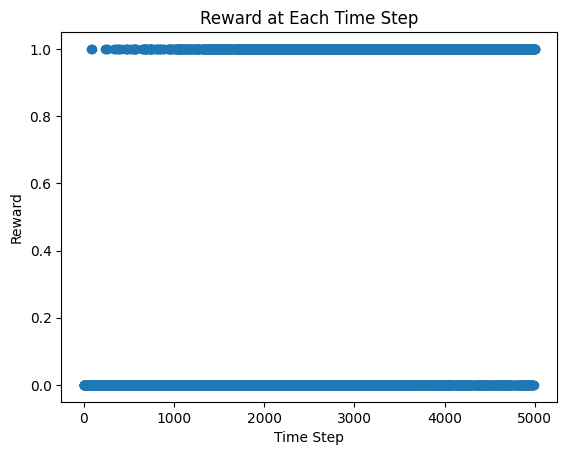

In [ ]:
plt.plot(rewards, 'o')
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.title('Reward at Each Time Step')
plt.show()

Really good results! Accuracy of 43%

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    state = one_hot_encode(state, nspace)
    state = torch.tensor([state], device=device)
    done = False
    epsilon = 0
    tl = 0
    for t in range(max_steps):
        vid.capture_frame()
        with torch.no_grad():
            action = policy_net(state).max(1)[1].view(1, 1)
        next_state, reward, done, info, _ = env.step(action.item())
        next_state = one_hot_encode(next_state, nspace)
        tl+=reward
        next_state = torch.tensor([next_state], device=device)
        # print(f"state: {state}, action: {action.item()}",next_state, reward, done)
        state = next_state
        if done:
            break
    vid.close()
    env.close()
    print(tl)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
show_video_of_model("FrozenLake-v1")

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment FrozenLake-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.

1.0


In [ ]:
show_video("FrozenLake-v1")